In [1]:
import torch
import deepvelo as dv 
import scanpy as sc

/mnt/data2/home/leonardo/miniconda3/envs/deepvelo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch


In [2]:
adata = sc.read_h5ad("/mnt/data2/home/leonardo/git/imVelo/benchmark/deepvelo/forebrain/deepvelo_forebrain.h5ad")
checkpoint = torch.load("/mnt/data2/home/leonardo/git/imVelo/benchmark/deepvelo/forebrain/trainer.pth")


In [4]:
print(checkpoint.keys())

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.1.weight', 'layers.1.bias', 'layers.2.weight', 'layers.2.bias'])


In [19]:
from deepvelo.model.model import VeloModel

import torch
import torch.nn.functional as F
from deepvelo.model.model import VeloModel  # Import the VeloModel class

# Assuming you have the number of genes from your data
n_genes = adata.n_vars  # Number of genes in your dataset

# Instantiate the VeloModel (adjust layers if needed)
model = VeloModel(n_genes=n_genes, layers=[256, 64])

# Manually load the weights for each fully connected layer
model.fc1.weight.data = checkpoint['layers.0.weight'].T
model.fc1.bias.data = checkpoint['layers.0.bias'].T

model.fc2.weight.data = checkpoint['layers.1.weight'].T
model.fc2.bias.data = checkpoint['layers.1.bias'].T

model.fc3.weight.data = checkpoint['layers.2.weight'].T
model.fc3.bias.data = checkpoint['layers.2.bias'].T

# Set the model to evaluation mode
model.eval()

VeloModel(
  (fc1): Linear(in_features=4898, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4898, bias=True)
)

In [23]:
adata

AnnData object with n_obs × n_vars = 1720 × 2449
    obs: 'Clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'isomap_1', 'isomap_2', 'isomap_3', 'isomap_1+2', 'isomap_1+3', 'isomap_2+3', 'pca_1', 'pca_2', 'pca_3', 'pca_1+2', 'pca_1+3', 'pca_2+3', 'isomap_1_ve', 'isomap_2_ve', 'isomap_3_ve', 'isomap_1_MuMs', 'isomap_2_MuMs', 'isomap_3_MuMs', 'isomap_1_z', 'isomap_2_z', 'isomap_3_z', 'isomap_1_velocity', 'isomap_2_velocity', 'isomap_3_velocity', 'isomap_1_velocity_concat', 'isomap_2_velocity_concat', 'isomap_3_velocity_concat', 'isomap_1_PCA', 'isomap_2_PCA', 'isomap_3_PCA', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'directional_variance', 'directional_difference', 'directional_cosine_sim_variance', 'directional_cosine_sim_difference', 'directional_cosine_sim_mean', 'velocities_miVelo_0_self_transition', 'velocities_miVelo_1_self_transiti

In [22]:
predicted_velocities_numpy.shape

(1720, 7347)

In [31]:
import torch
import torch.nn.functional as F

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you've already instantiated your model
# Move the model to the appropriate device
model.to(device)

# Prepare the input data and move to the correct device
x_u = torch.Tensor(adata.layers["Mu"]).to(device)  # unspliced RNA
x_s = torch.Tensor(adata.layers["Ms"]).to(device)  # spliced RNA

# Forward pass through the network and extract intermediate outputs (latent embedding from fc2)
with torch.no_grad():
    # Concatenate unspliced and spliced RNA as input
    x = torch.cat([x_u, x_s], dim=1)
    
    # First hidden layer
    x = F.relu(model.fc1(x))
    
    # Latent embedding from the second hidden layer
    latent_embedding = F.relu(model.fc2(x))
    
    # Final prediction from the third layer
    predicted_velocities = model.fc3(latent_embedding)

n_genes = adata.n_vars  # Number of genes in the dataset
predicted_velocities_spliced = predicted_velocities[:, :n_genes]  # Spliced predictions

# Convert the spliced latent embeddings to NumPy for further use
latent_embedding_numpy = latent_embedding.cpu().numpy()

# Optionally, store the latent embeddings in the AnnData object
adata.obsm['z'] = latent_embedding_numpy

# Convert the spliced predicted velocities to NumPy and store in AnnData
predicted_velocities_numpy = predicted_velocities_spliced.cpu().numpy()
adata.layers["velocity"] = predicted_velocities_numpy

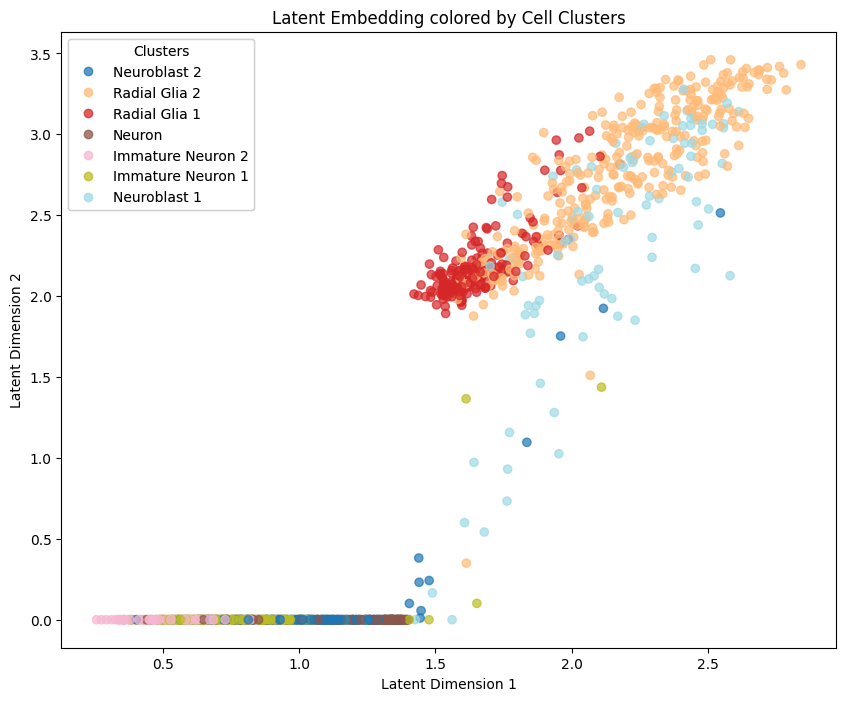

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assume latent_embedding_numpy and adata.obs["Clusters"] are already available

# Create a color map based on unique cell types in 'Clusters'
clusters = adata.obs["Clusters"]
unique_clusters = clusters.unique()
n_clusters = len(unique_clusters)

# Assign a unique color to each cluster
colors = plt.cm.get_cmap("tab20", n_clusters)

# Create a mapping from cell types to color indices
cluster_to_color = {cluster: i for i, cluster in enumerate(unique_clusters)}

# Assign a color to each cell based on its cluster
color_indices = [cluster_to_color[cluster] for cluster in clusters]

# Convert latent_embedding_numpy to 2D for visualization (e.g., using PCA or t-SNE if needed)
# Assuming latent_embedding_numpy is already 2D (shape: n_cells x 2)

# Plot the latent embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_embedding_numpy[:, 0], latent_embedding_numpy[:, 1],
                      c=color_indices, cmap="tab20", alpha=0.7)

# Create a legend with unique clusters
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=unique_clusters, title="Clusters")
plt.gca().add_artist(legend1)

# Add labels and title
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Embedding colored by Cell Clusters')

# Show the plot
plt.show()


In [29]:
import scvelo as scv

In [32]:
sc.pp.neighbors(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color="Clusters")

computing velocity graph (using 1/24 cores)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 4) + inhomogeneous part.

In [28]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata)
sc.pl.umap(adata, color="Clusters")

AttributeError: 'ColormapRegistry' object has no attribute 'get_cmap'

In [7]:
print(dir(dv.model))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'layers', 'loss', 'metric', 'model']


In [6]:
print(dir(dv))

['AnnData', 'Callable', 'ConfigParser', 'Constants', 'Mapping', 'MetaConstants', 'Trainer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'base', 'data_loader', 'deepcopy', 'logg', 'logger', 'model', 'module_arch', 'module_data', 'module_loss', 'module_metric', 'np', 'parse_config', 'pipe', 'pipeline', 'pl', 'plot', 'tl', 'tool', 'torch', 'train', 'trainer', 'utils']


In [ ]:
import umap
reducer = umap.UMAP()
latent_umap = reducer.fit_transform(latent_embedding_numpy)

# Plot the UMAP
import matplotlib.pyplot as plt
plt.scatter(latent_umap[:, 0], latent_umap[:, 1], c=adata.obs['cell_type'], cmap='Spectral')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP projection of latent embeddings')
plt.show()


In [8]:
print(dir(dv.model.model))

['ApplyNodeFunc', 'BaseModel', 'DGLGraph', 'F', 'GINLayer', 'GraphConv', 'MLP', 'MnistModel', 'NodeUpdate', 'VeloGCN', 'VeloGCNNodeFlow', 'VeloGIN', 'VeloModel', 'VeloTransformer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'dgl', 'fn', 'nn', 'torch']


In [14]:
def plot_phase_plane(adata, gene_name, u_scale=0.01, s_scale=0.01, alpha=0.5, head_width=0.02, head_length=0.03,
                     length_includes_head=False, log=False, norm_velocity=True, filter_cells=False,
                     smooth_expr=True, show_plot=True, save_plot=True, save_path=".",
                     cell_type_key="clusters"):
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.sparse

    # Extract expression data
    gene_idx = adata.var_names.get_loc(gene_name)
    if smooth_expr:
        unspliced_expression = adata.layers["Mu"][:, gene_idx]
        spliced_expression = adata.layers["Ms"][:, gene_idx]
    else:
        unspliced_expression = adata.layers["unspliced"][:, gene_idx]
        spliced_expression = adata.layers["spliced"][:, gene_idx]

    # Convert to dense arrays if needed
    if scipy.sparse.issparse(unspliced_expression):
        unspliced_expression = unspliced_expression.toarray().flatten()
    else:
        unspliced_expression = np.asarray(unspliced_expression).flatten()

    if scipy.sparse.issparse(spliced_expression):
        spliced_expression = spliced_expression.toarray().flatten()
    else:
        spliced_expression = np.asarray(spliced_expression).flatten()

    # Normalize the expression data
    unspliced_expression_min = np.min(unspliced_expression)
    unspliced_expression_max = np.max(unspliced_expression)
    spliced_expression_min = np.min(spliced_expression)
    spliced_expression_max = np.max(spliced_expression)

    # Avoid division by zero
    if unspliced_expression_max - unspliced_expression_min != 0:
        unspliced_expression = (unspliced_expression - unspliced_expression_min) / \
                               (unspliced_expression_max - unspliced_expression_min)
    else:
        unspliced_expression = unspliced_expression - unspliced_expression_min

    if spliced_expression_max - spliced_expression_min != 0:
        spliced_expression = (spliced_expression - spliced_expression_min) / \
                             (spliced_expression_max - spliced_expression_min)
    else:
        spliced_expression = spliced_expression - spliced_expression_min

    # Extract the velocity data
    unspliced_velocity = adata.layers['velocity_u'][:, gene_idx]
    spliced_velocity = adata.layers['velocity'][:, gene_idx]

    # Convert to dense arrays if needed
    if scipy.sparse.issparse(unspliced_velocity):
        unspliced_velocity = unspliced_velocity.toarray().flatten()
    else:
        unspliced_velocity = np.asarray(unspliced_velocity).flatten()

    if scipy.sparse.issparse(spliced_velocity):
        spliced_velocity = spliced_velocity.toarray().flatten()
    else:
        spliced_velocity = np.asarray(spliced_velocity).flatten()

    # Normalize velocities if required
    def custom_scale(data):
        max_abs_value = np.max(np.abs(data))
        if max_abs_value != 0:
            scaled_data = data / max_abs_value
        else:
            scaled_data = data
        return scaled_data

    if norm_velocity:
        unspliced_velocity = custom_scale(unspliced_velocity)
        spliced_velocity = custom_scale(spliced_velocity)

    # Log transform if required
    if log:
        unspliced_velocity = np.log1p(unspliced_velocity)
        spliced_velocity = np.log1p(spliced_velocity)

    # Generate boolean masks for conditions and apply them
    if filter_cells:
        valid_idx = (unspliced_expression > 0) & (spliced_expression > 0)
    else:
        valid_idx = (unspliced_expression >= 0) & (spliced_expression >= 0)

    # Filter data based on valid_idx
    unspliced_expression_filtered = unspliced_expression[valid_idx]
    spliced_expression_filtered = spliced_expression[valid_idx]
    unspliced_velocity_filtered = unspliced_velocity[valid_idx]
    spliced_velocity_filtered = spliced_velocity[valid_idx]

    # Also filter cell type information to match the filtered expressions
    cell_types_filtered = adata.obs[cell_type_key][valid_idx]

    # Prepare colors for plotting
    unique_cell_types = adata.obs[cell_type_key].cat.categories
    celltype_colors = adata.uns[f"{cell_type_key}_colors"]
    celltype_to_color = dict(zip(unique_cell_types, celltype_colors))
    colors = cell_types_filtered.map(celltype_to_color).to_numpy()

    # Plot the scatter plot
    plt.figure(figsize=(9, 6.5), dpi=100)
    scatter = plt.scatter(spliced_expression_filtered, unspliced_expression_filtered, c=colors, alpha=0.6)

    # Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        # Extract scalar values
        unspliced_vel = unspliced_velocity_filtered[i]
        spliced_vel = spliced_velocity_filtered[i]

        # Ensure the velocities are scalar floats
        if isinstance(unspliced_vel, np.ndarray):
            unspliced_vel = unspliced_vel.item()
        if isinstance(spliced_vel, np.ndarray):
            spliced_vel = spliced_vel.item()

        # Handle any potential issues with non-float values
        try:
            unspliced_vel = float(unspliced_vel)
            spliced_vel = float(spliced_vel)
        except (ValueError, TypeError):
            print(f"Non-numeric value encountered at index {i}. Skipping this point.")
            continue

        # Proceed with plotting
        cell_type = cell_types_filtered.iloc[i]
        arrow_color = celltype_to_color[cell_type]
        plt.arrow(
            spliced_expression_filtered[i], unspliced_expression_filtered[i],
            spliced_vel * s_scale, unspliced_vel * u_scale,
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length,
            length_includes_head=length_includes_head
        )

    plt.xlabel(f'Normalized Spliced Expression of {gene_name}')
    plt.ylabel(f'Normalized Unspliced Expression of {gene_name}')
    plt.title(f'Expression and Velocity of {gene_name} by Cell Type')

    # Create a legend
    patches = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=celltype_to_color[celltype], markersize=10, label=celltype)
               for celltype in unique_cell_types]
    plt.legend(handles=patches, title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    if save_plot:
        plt.savefig(save_path, format='png', bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {save_path}")

    if show_plot:
        plt.show()
    else:
        plt.close()


In [ ]:
plot_phase_plane(adata, "Gnas")

AttributeError: 'NoneType' object has no attribute 'write'

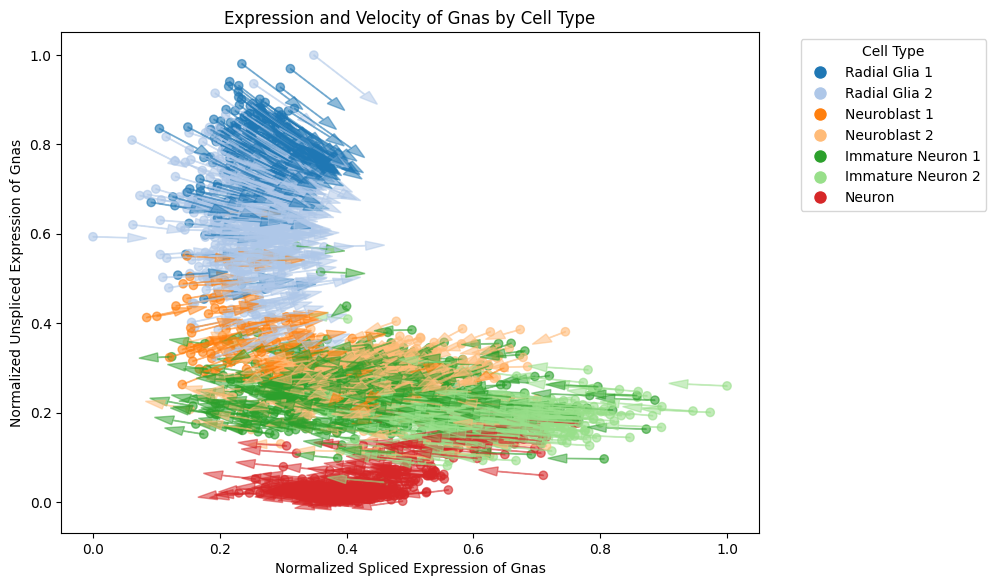

In [17]:
plot_phase_plane(adata, "Gnas", u_scale=0.1, s_scale=0.1, save_path=None, show_plot=True, cell_type_key="Clusters")

In [ ]:
adata.layers

In [ ]:
adata.layers["velocity_unspliced"]